# **[Alpha Vantage](https://www.alphavantage.co/documentation/) Trading Strategy**
---

In [4]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0,10.0)

from alpha_vantage.timeseries import TimeSeries

In [5]:
stock = 'GOOG'

## Import Data

In [44]:
ts = TimeSeries(key = 'ALPHA_VANTAGE_API_KEY',output_format = 'pandas')
data, meta_data = ts.get_daily(symbol = stock, outputsize = 'full')

meta_data

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'GOOG',
 '3. Last Refreshed': '2022-03-03',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

In [45]:
data.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2022-03-03,2719.570,2734.2759,2668.620,2686.16,963055.0
2022-03-02,2692.165,2712.3100,2668.650,2695.03,1198337.0
2022-03-01,2689.600,2722.2200,2667.570,2683.36,1231996.0
2022-02-28,2665.690,2712.8100,2656.505,2697.82,1483784.0
2022-02-25,2670.510,2707.7800,2635.300,2690.39,1311793.0


## Clean Pandas DataFrame

In [46]:
columns = ['open', 'high', 'low', 'close', 'volume']
data.columns = columns

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1999 entries, 2022-03-03 to 2014-03-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1999 non-null   float64
 1   high    1999 non-null   float64
 2   low     1999 non-null   float64
 3   close   1999 non-null   float64
 4   volume  1999 non-null   float64
dtypes: float64(5)
memory usage: 93.7 KB


In [47]:
day = np.arange(1,len(data) + 1)
data['day'] = day 

data.drop(columns=['volume'],inplace = True)
data = data[['day','open','high','low','close']]
data.head()

,day,open,high,low,close
date,,,,,
2022-03-03,1,2719.570,2734.2759,2668.620,2686.16
2022-03-02,2,2692.165,2712.3100,2668.650,2695.03
2022-03-01,3,2689.600,2722.2200,2667.570,2683.36
2022-02-28,4,2665.690,2712.8100,2656.505,2697.82
2022-02-25,5,2670.510,2707.7800,2635.300,2690.39


---
# Momentum Trading Strategy
---

## Moving Averages

In [49]:
data['9-day'] = data['close'].rolling(9).mean()
data['21-day'] = data['close'].rolling(21).mean()
data[19:25]

,day,open,high,low,close,9-day,21-day
date,,,,,,,
2022-02-03,20,2905.90,2982.3544,2844.1000,2853.01,2777.174444,NaN
2022-02-02,21,3037.27,3042.0000,2911.1501,2960.73,2802.976667,2724.121429
2022-02-01,22,2756.70,2764.0000,2691.3645,2757.57,2808.706667,2727.521905
2022-01-31,23,2683.96,2716.8700,2645.4800,2713.97,2812.192222,2728.423810
2022-01-28,24,2600.00,2667.4100,2573.8900,2665.79,2800.385556,2727.587143
2022-01-27,25,2627.22,2652.1988,2578.9000,2582.42,2772.981111,2722.091905


## Signals

In [51]:
data['signal'] = np.where(data['9-day'] > data['21-day'],1,0)
data['signal'] = np.where(data['9-day'] < data['21-day'],-1,data['signal'])
data.dropna(inplace=True)
data.head()

,day,open,high,low,close,9-day,21-day,signal
date,,,,,,,,
2022-02-02,21,3037.27,3042.0000,2911.1501,2960.73,2802.976667,2724.121429,1
2022-02-01,22,2756.70,2764.0000,2691.3645,2757.57,2808.706667,2727.521905,1
2022-01-31,23,2683.96,2716.8700,2645.4800,2713.97,2812.192222,2728.423810,1
2022-01-28,24,2600.00,2667.4100,2573.8900,2665.79,2800.385556,2727.587143,1
2022-01-27,25,2627.22,2652.1988,2578.9000,2582.42,2772.981111,2722.091905,1


## Instantaneous Returns/System Returns

In [52]:
data['return'] = np.log(data['close']).diff()
data['system_return'] = data['signal'] * data['return']
data['entry'] = data.signal.diff()
data.head()

,day,open,high,low,close,9-day,21-day,signal,return,system_return,entry
date,,,,,,,,,,,
2022-02-02,21,3037.27,3042.0000,2911.1501,2960.73,2802.976667,2724.121429,1,NaN,NaN,NaN
2022-02-01,22,2756.70,2764.0000,2691.3645,2757.57,2808.706667,2727.521905,1,-0.071086,-0.071086,0.0
2022-01-31,23,2683.96,2716.8700,2645.4800,2713.97,2812.192222,2728.423810,1,-0.015937,-0.015937,0.0
2022-01-28,24,2600.00,2667.4100,2573.8900,2665.79,2800.385556,2727.587143,1,-0.017912,-0.017912,0.0
2022-01-27,25,2627.22,2652.1988,2578.9000,2582.42,2772.981111,2722.091905,1,-0.031774,-0.031774,0.0


---
# Plot Time Series
---

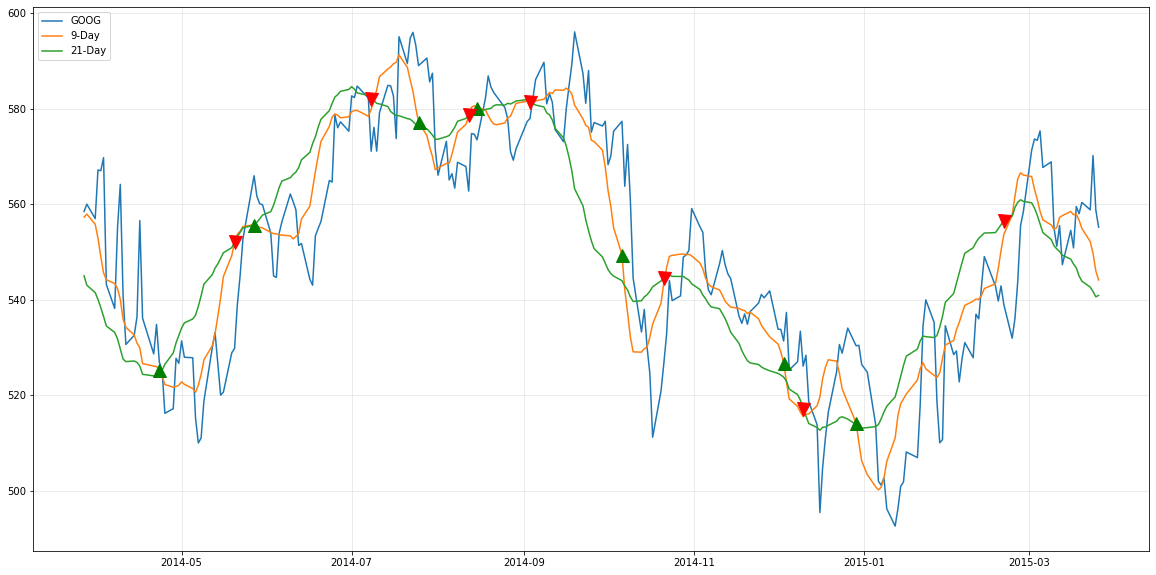

In [56]:
plt.grid(True, alpha = .3)

plt.plot(data.iloc[-252:]['close'], label = stock)
plt.plot(data.iloc[-252:]['9-day'], label = '9-Day')
plt.plot(data.iloc[-252:]['21-day'], label = '21-Day')

# when the signal postively changes -> green arrow up on the '9-Day' line
plt.plot(data[-252:].loc[data.entry == 2].index, data[-252:]['9-day'][data.entry == 2], '^', color = 'g', markersize = 13)
# when the signal negatively changes -> red arrow down on the '21-Day' line
plt.plot(data[-252:].loc[data.entry == -2].index, data[-252:]['21-day'][data.entry == -2], 'v', color = 'r', markersize = 13)

plt.legend(loc=2)

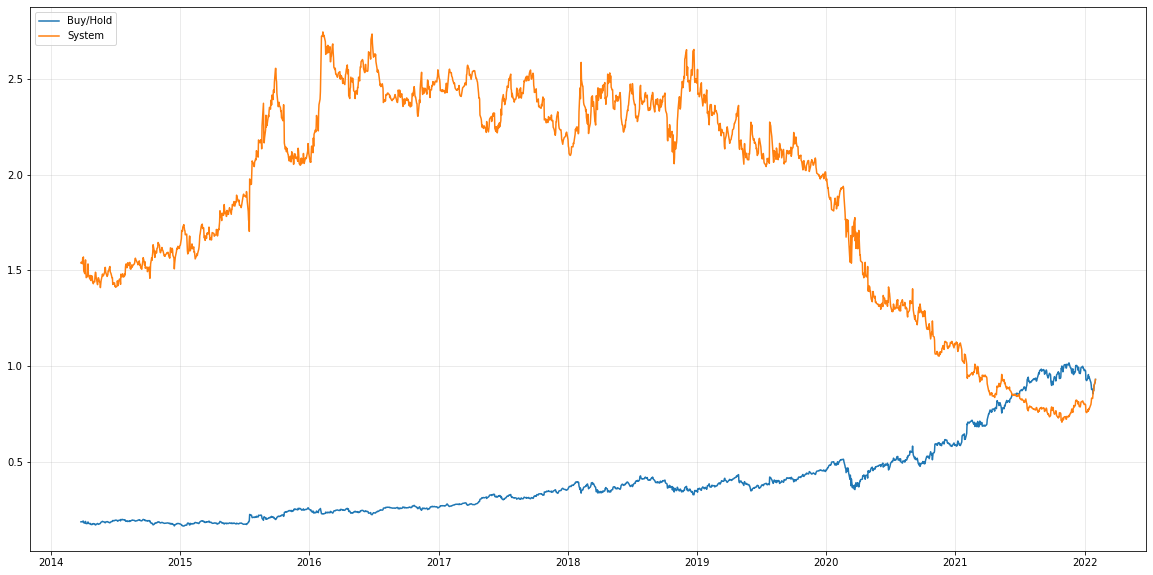

In [57]:
plt.plot(np.exp(data['return']).cumprod(), label = 'Buy/Hold')
plt.plot(np.exp(data['system_return']).cumprod(), label = 'System')
plt.legend(loc=2)
plt.grid(True, alpha = .3)

In [58]:
np.exp(data['return']).cumprod()[-1]-1

-0.8113775994433812

In [59]:
np.exp(data['system_return']).cumprod()[-1]-1

0.5393752962839682